# Generative Adversarial Networks (solución)

En este ejercicio utilizaremos los conceptos aprendidos de GAN para crear nuevas imágenes de caracteres del alfabeto. Trabajaremos con un dataset con letras escritas a mano. Utilizaremos las letras del alfabeto hasta la letra J por temas de practicidad.

El ejercicio consiste en los siguientes pasos:

1. Cargar los datos
2. Crear un modelo para el generador
3. Crear un modelo para el discriminador
4. Juntar ambas partes para generar el GAN
5. Entrenar el GAN
6. Crear imágenes nuevas

## 1 - Cargar los datos

Si están trabajando localmente, primero instalen las liberarías necesarias para este ejercicio.

In [1]:
%%bash
#pip install tqdm
#conda install tqdm

### Importaremos todas las liberías que utilizaremos a lo largo del ejercicio.

In [2]:
%matplotlib inline
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dropout, Flatten, Dense, BatchNormalization, Reshape, UpSampling2D, Activation
from keras.optimizers import Adam, sgd
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
from skimage import io
from skimage.transform import resize

np.random.seed(0)

/Users/rodrigobeceiro/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Cargamos las imágenes de nuestro dataset ya clasificado.

In [3]:
image_coll = ['A', 'B', 'C','D','E','F','G','H','I','J'] 
# Variable para los datos de entrenamiento
X_train = []
for collections in image_coll:
    print('Cargando letra: ' + collections)
    coll = io.ImageCollection('data/' + collections + '/*.png')
    for img in coll:
        X_train.append(resize(img,(28,28,1)))

Cargando letra: A


/Users/rodrigobeceiro/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Cargando letra: B
Cargando letra: C
Cargando letra: D
Cargando letra: E
Cargando letra: F
Cargando letra: G
Cargando letra: H
Cargando letra: I
Cargando letra: J


Transformar X_train en un array de numpy

In [4]:
### SOLUCIÓN
X_train = np.array(X_train)

Verificar el shape de X_train

In [5]:
### SOLUCIÓN
print(X_train.shape)

(18724, 28, 28, 1)


** ¿Qué significa cada uno de los números del shape?**

** Respuesta: ** Que tengo un total de 18724 imágenes de tamaño 28x28 en blanco y negro.

### Analizo algunas de las imágenes que tengo disponibles.

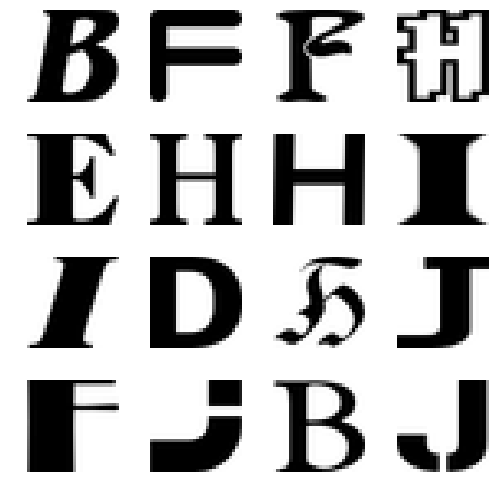

In [6]:
index = np.random.choice(X_train.shape[0],16)
samples = X_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Normalizo las imágenes

In [7]:
### SOLUCIÓN
img_rows = 28
img_cols = 28 

** ¿En qué rango están nuestros datos? **

** Respuesta: ** En el rango 0-1

Verifiquemos el rango de nuestros datos.

In [8]:
### SOLUCIÓN
print(np.min(X_train), np.max(X_train))

0.0 1.0


Llevar nuestros datos al rango [-1.0,1.0]

In [9]:
### SOLUCIÓN
X_train = (X_train.astype('float32') -0.5)/0.5

Verifiquemos nuevamente el rango de nuestros datos.

In [10]:
### SOLUCIÓN
print(np.min(X_train), np.max(X_train))

-1.0 1.0


In [11]:
print('Shape de X_train:', X_train.shape)
print('Cantidad de muestras:',X_train.shape[0])

Shape de X_train: (18724, 28, 28, 1)
Cantidad de muestras: 18724


## 2 - Crear un modelo para el generador
A continuación armamos la red neuronal para el generador de nuestro GAN.

In [12]:
shp = X_train.shape[1:]
inidim = 100
dropout_rate = 0.3
opt = Adam(lr=2e-4,beta_1=0.5)

# Generador
g_input = Input(shape=[inidim])
H = Dense(7*7*128, kernel_initializer='glorot_normal')(g_input)
H = LeakyReLU(0.2)(H)
H = Reshape( [7, 7, 128] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform')(H)
H = LeakyReLU(0.2)(H)
H = UpSampling2D(size=(2, 2))(H)
H = Conv2D(1, (5, 5), padding='same', kernel_initializer='glorot_uniform')(H)
g_V = Activation('tanh')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

## 3 - Crear un modelo para el discriminador
Crear el modelo del discriminador con las siguientes capas:
1. Capa de input con el shape necesario
2. Capa convolucional de 64 filtros, kernel de 5x5, stride de (2,2) y padding same
3. LeakyRelu de alpha 0.2
4. Capa de dropout
5. Capa convolucional de 128 filtros, kernel de 5x5, stride de (2,2) y padding same
6. LeakyRelu de alpha 0.2
7. Capa de dropout
8. Capa de Flatten
9. Capa densa de salida con activación sigmoid

También utilizar un optimizador igual al del generador y compilarlo con función de pérdida binary crossentropy.

** ¿Qué input shape precisa el discriminador y por qué?**

** Respuesta: ** Debe ser de forma shp porque es la forma de mis datos de entrenamiento y a la vez es la salida del generador.

** ¿Cuántos nodos preciso a la salida y por qué?**

** Respuesta: ** Utilizo dos nodos para poder clasificar la imagen como generada o parte del dataset.

In [13]:
### SOLUCIÓN
# Discriminador
dopt = Adam(lr=2e-4,beta_1=0.5)
d_input = Input(shape=shp)
H = Conv2D(64, (5, 5), strides=(2, 2), padding= 'same')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Conv2D(128, (5, 5), strides=(2, 2), padding = 'same')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
d_V = Dense(2,activation='sigmoid')(H)

discriminator = Model(d_input,d_V)
discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
__________

## 4 - Juntar ambas partes para generar el GAN
Ahora que tenemos un modelo para el generador y otro para el discriminador debemos juntarlos para obtener el GAN.

In [14]:
# Congelo los pesos del discriminador para que no se entrenen en principio
discriminator.trainable = False

Creemos una capa input para nuestro modelo:

In [15]:
### SOLUCIÓN
gan_input = Input(shape=[inidim])

Agreguemos el generador a continuación de la capa input. Guardemos eso en la variable 'x'.

In [16]:
### SOLUCIÓN
x = generator(gan_input)

Agreguemos el discriminador a continuación del generador.

In [17]:
### SOLUCIÓN
gan_V = discriminator(x)

In [18]:
GAN = Model(gan_input, gan_V)

Compilar el modelo con función de pérdida binary_crossentropy y el optimizador definido (opt)

In [19]:
### SOLUCIÓN
GAN.compile(loss='binary_crossentropy', optimizer=opt)

In [20]:
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         839937    
_________________________________________________________________
model_2 (Model)              (None, 2)                 219138    
Total params: 1,059,075
Trainable params: 839,937
Non-trainable params: 219,138
_________________________________________________________________


## 5 - Entrenar el GAN
Defino funciones auxiliares para poder visualizar el avance del entrenamiento.

In [21]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='Pérdida del discriminador')
        plt.plot(losses["g"], label='Pérdida del generador')
        plt.legend()
        plt.show()

In [22]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(7,7) ):
    noise = np.random.normal(0,1,size=[n_ex,inidim])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img,interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


### Pre-entreno al discriminador para obtener mejores resultados cuando se entrene junto con el generador 

In [23]:
# Número de iteraciones
ntrain = 5000
# Tomo datos al azar para entrenar
trainidx = np.random.choice(X_train.shape[0], ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-entrenar al discriminador
#Genero ruido
noise_gen = np.random.normal(0,1,size=[XT.shape[0],inidim])
#Genero imágenes con el generador a partir del ruido
generated_images = generator.predict(noise_gen)
#Junto las imágenes generadas con las originales del dataset
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
#Trato de engañar al discriminador diciendo que todas las imágenes son reales
y[:n,1] = 1
y[n:,0] = 1

#Permito cambiar los pesos del discriminador
discriminator.trainable = True
#Pre-entreno
discriminator.fit(X,y, epochs=1, batch_size=32)


Epoch 1/1
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0843


In [24]:
#Predigo
y_hat = discriminator.predict(X)

#Analizo los resultados del discriminador pre-entrenado
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Precisión: %0.02f imágenes (%d de %d) correctas"%(acc, n_rig, n_tot))

Precisión: 100.00 imágenes (10000 de 10000) correctas


Defino una función para ayudarme a entrenar el GAN

In [25]:
# Defino un vector de pérdidas del generador y discriminador
losses = {"d":[], "g":[]}

In [26]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        ########################################
        ######   GENERO IMÁGENES NUEVAS
        ########################################
        
        # Creo imágenes a partir del ruido con el generador
        image_batch = X_train[np.random.choice(X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.normal(0,1,size=[BATCH_SIZE,inidim])
        generated_images = generator.predict(noise_gen)
        
        ########################################
        ######   ENTRENO AL DISCRIMINADOR
        ########################################
        
        # Entreno al discriminador con las imágenes generadas
        #Junto imágenes generadas con imágenes del dataset original
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        #Trato de engañar al discriminador
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        #Permito entrenar al discriminador
        discriminator.trainable = True
        #Entreno
        d_loss  = discriminator.train_on_batch(X,y)
        #Guardo las pérdidas del discriminador
        losses["d"].append(d_loss)
    
        ########################################
        ######   ENTRENO AL GENERADOR
        ########################################
        # Congelo los pesos del discriminador para que no se modifiquen en esta parte del entrenamiento del GAN
        discriminator.trainable = False
        for i in range(1):
            noise_tr = np.random.normal(0,1,size=[BATCH_SIZE,inidim])
            y2 = np.zeros([BATCH_SIZE,2])
            y2[:,1] = 1
            # Entrenamiento
            g_loss = GAN.train_on_batch(noise_tr, y2 )
        
        #Guardo las pérdidas del generador
        losses["g"].append(g_loss)
        
        # Actualizo las gráficas cada plt_frq iteraciones
        if e%plt_frq==0:
            plot_loss(losses)
            plot_gen()
        

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

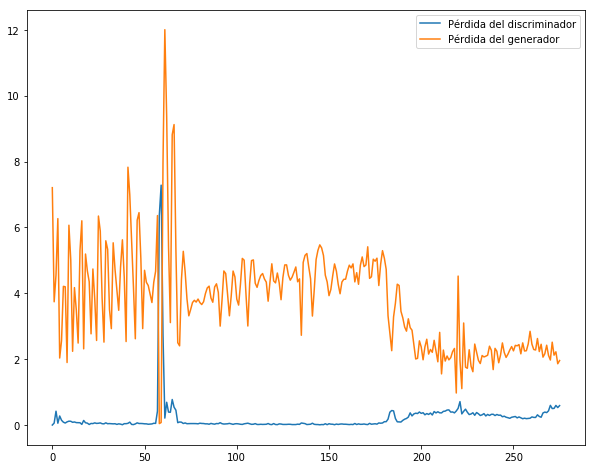

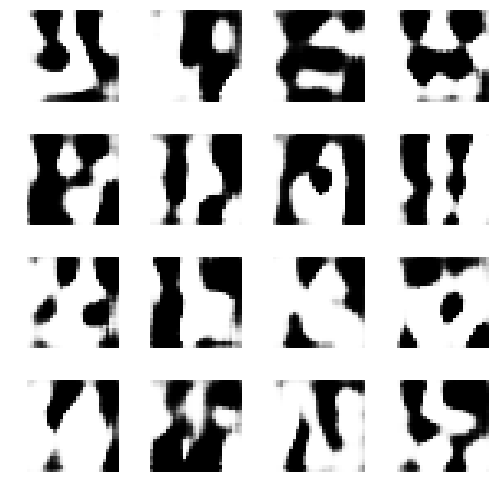

  3%|▎         | 39/1500 [01:41<1:03:28,  2.61s/it]

In [ ]:
#Llamo a la función para entrenar
train_for_n(nb_epoch=1500, plt_frq=25,BATCH_SIZE=128)

** ¿Qué pasó entorno a las 60 interaciones del entrenamiento? **

** Respuesta: ** El generador encontró una falla en el discriminador y la explotó hasta que el discriminador se dio cuenta y lo corrigió.

## 6 - Crear imágenes nuevas
Llamando a la función plot_gen() puedo generar nuevos datos ahora que ya entrené al GAN.

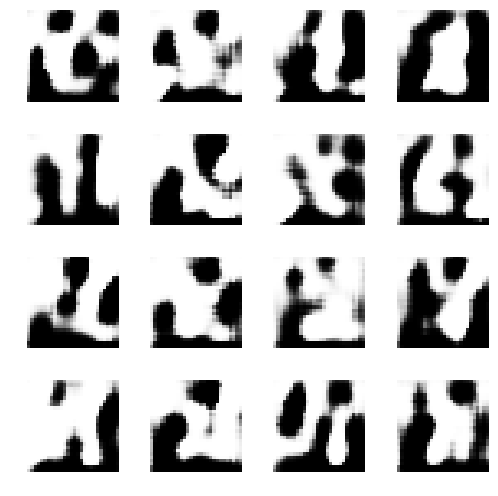

In [28]:
plot_gen()

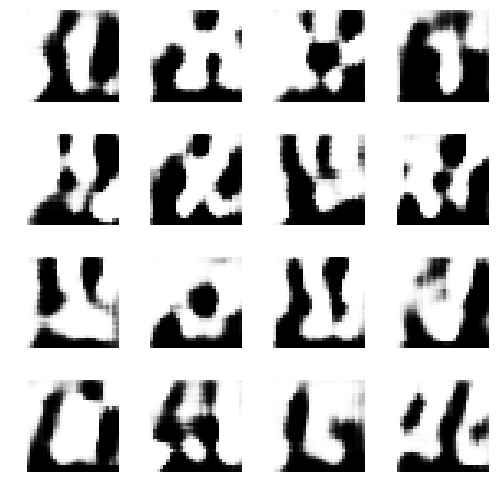

In [29]:
plot_gen()

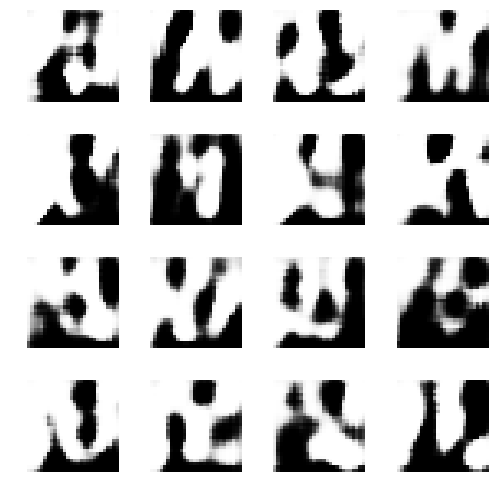

In [30]:
plot_gen()